# Importing Libraries

In [388]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import seaborn as sns
from persiantools.jdatetime import JalaliDate
from mpl_toolkits.basemap import Basemap

# Data Preparation

## Loading Datasets

In [389]:
geography = pd.read_csv(f"Dataset/Geography Information.csv")
geography['city'] = geography['city'].str.strip()
print(geography)

    latitude  longitude  elevation          city
0  35.676624  51.428570     1183.0        Tehran
1  38.066784  46.150738     1399.0        Tabriz
2  36.309315  59.648438      986.0       Mashhad
3  32.653778  51.695120     1579.0       Isfahan
4  29.630930  52.560837     1541.0        Shiraz
5  31.318100  48.700836       23.0         Ahvaz
6  37.293495  49.535810        4.0         Rasht
7  30.263618  57.119434     1762.0        Kerman
8  27.170473  56.224940        9.0  Bandar Abbas
9  35.817223  50.980644     1341.0         Karaj


In [390]:
# City name lists
cities = [
    "Tehran",
    "Tabriz",
    "Mashhad",
    "Isfahan",
    "Shiraz",
    "Ahvaz",
    "Rasht",
    "Kerman",
    "Bandar Abbas",
    "Karaj"
]

# list to keep dataframes
dataframes = []

# Reading DataFrames and Saving them in a dictionary
for city in cities:
    df = pd.read_csv(f"Dataset/{city}.csv")
    df['city'] = city
    dataframes.append(df)

### Dataset Combining 

In [391]:
## Data Cleaning 
df_combined = pd.concat(dataframes, ignore_index=True)
df_combined = pd.merge(df_combined, geography, on='city', how='left')

# Save the combined dataframe to a new CSV file
df_combined.to_csv("Dataset/Combined Dataset.csv", index=False)

## Data Cleaning 

In [392]:
del df, df_combined, dataframes, geography, cities
df = pd.read_csv("Dataset/Combined Dataset.csv")

### Checking NaNs 

In [393]:
print("Dataset Missing Values:")
missing_values = df.isnull().sum()
print(missing_values)

Dataset Missing Values:
time                               0
temp_max (°C)                      0
temp_min (°C)                      0
temp_mean (°C)                     0
daylight_duration (s)              0
precipitation_sum (mm)             0
rain_sum (mm)                      0
snowfall_sum (cm)                  0
precipitation_hours (h)            0
wind_speed_max (km/h)              0
wind_gusts_max (km/h)              0
wind_direction_dominant (°)        0
shortwave_radiation_sum (MJ/m²)    0
evapotranspiration (mm)            0
city                               0
latitude                           0
longitude                          0
elevation                          0
dtype: int64


### Gregorian and Jalali Date Settings 

In [394]:
df["time"] = pd.to_datetime(df["time"])

In [395]:
# create Jalali date column
df["date_jalali"] = df["time"].apply(lambda time: JalaliDate(time)) 

# rename time to date_gregorian
df.rename(columns={'time': 'date_gregorian'}, inplace=True)

In [396]:

df["year"] = df["date_jalali"].apply(lambda date: date.year)
df["month"] = df["date_jalali"].apply(lambda date: date.month)
df["season"] = df["month"].apply(lambda month:
                                    "Spring" if month in [1, 2, 3] else 
                                    "Summer" if month in [4, 5, 6] else 
                                    "Autumn" if month in [7, 8, 9] else 
                                    "Winter")
df['month'] = df['month'].map({
    1: "Farvardin",
    2: "Ordibehesht",
    3: "Khordad",
    4: "Tir",
    5: "Mordad",
    6: "Shahrivar",
    7: "Mehr",
    8: "Aban",
    9: "Azar",
    10: "Dey",
    11: "Bahman",
    12: "Esfand"
})                       

In [397]:
df["snowfall_sum (cm)"] = df["snowfall_sum (cm)"].apply(lambda item : item * 10)
df.rename(columns={'snowfall_sum (cm)': 'snowfall_sum (mm)'}, inplace=True)

In [398]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49260 entries, 0 to 49259
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   date_gregorian                   49260 non-null  datetime64[ns]
 1   temp_max (°C)                    49260 non-null  float64       
 2   temp_min (°C)                    49260 non-null  float64       
 3   temp_mean (°C)                   49260 non-null  float64       
 4   daylight_duration (s)            49260 non-null  float64       
 5   precipitation_sum (mm)           49260 non-null  float64       
 6   rain_sum (mm)                    49260 non-null  float64       
 7   snowfall_sum (mm)                49260 non-null  float64       
 8   precipitation_hours (h)          49260 non-null  float64       
 9   wind_speed_max (km/h)            49260 non-null  float64       
 10  wind_gusts_max (km/h)            49260 non-null  float64  

### Memory Cleaning 

In [399]:
def datatype_cleaner(df):
    
    for column in df.select_dtypes(include=['float', 'int']).columns:
        min_val = df[column].min()
        max_val = df[column].max()
    
        col_dtype = df[column].dtype
    
        # Check ranges for int and float types
        if np.issubdtype(col_dtype, np.floating):
            if min_val >= -65504 and max_val <= 65504:  # float16
                df[column] = df[column].astype(np.float16)
            elif min_val >= -3.4e38 and max_val <= 3.4e38:  # float32
                df[column] = df[column].astype(np.float32)
            else:
                df[column] = df[column].astype(np.float64)
    
        elif np.issubdtype(col_dtype, np.integer):
            if min_val >= -128 and max_val <= 127:  # int8
                df[column] = df[column].astype(np.int8)
            elif min_val >= -32768 and max_val <= 32767:  # int16
                df[column] = df[column].astype(np.int16)
            elif min_val >= -2147483648 and max_val <= 2147483647:  # int32
                df[column] = df[column].astype(np.int32)
            else:
                df[column] = df[column].astype(np.int64)

In [400]:
# calling the function to clean datatype memory usage
datatype_cleaner(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49260 entries, 0 to 49259
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   date_gregorian                   49260 non-null  datetime64[ns]
 1   temp_max (°C)                    49260 non-null  float16       
 2   temp_min (°C)                    49260 non-null  float16       
 3   temp_mean (°C)                   49260 non-null  float16       
 4   daylight_duration (s)            49260 non-null  float16       
 5   precipitation_sum (mm)           49260 non-null  float16       
 6   rain_sum (mm)                    49260 non-null  float16       
 7   snowfall_sum (mm)                49260 non-null  float16       
 8   precipitation_hours (h)          49260 non-null  float16       
 9   wind_speed_max (km/h)            49260 non-null  float16       
 10  wind_gusts_max (km/h)            49260 non-null  float16  

In [438]:
df.to_csv("Final Dataset.csv", index=False)

# Data Visualization

## Temperature Analysis

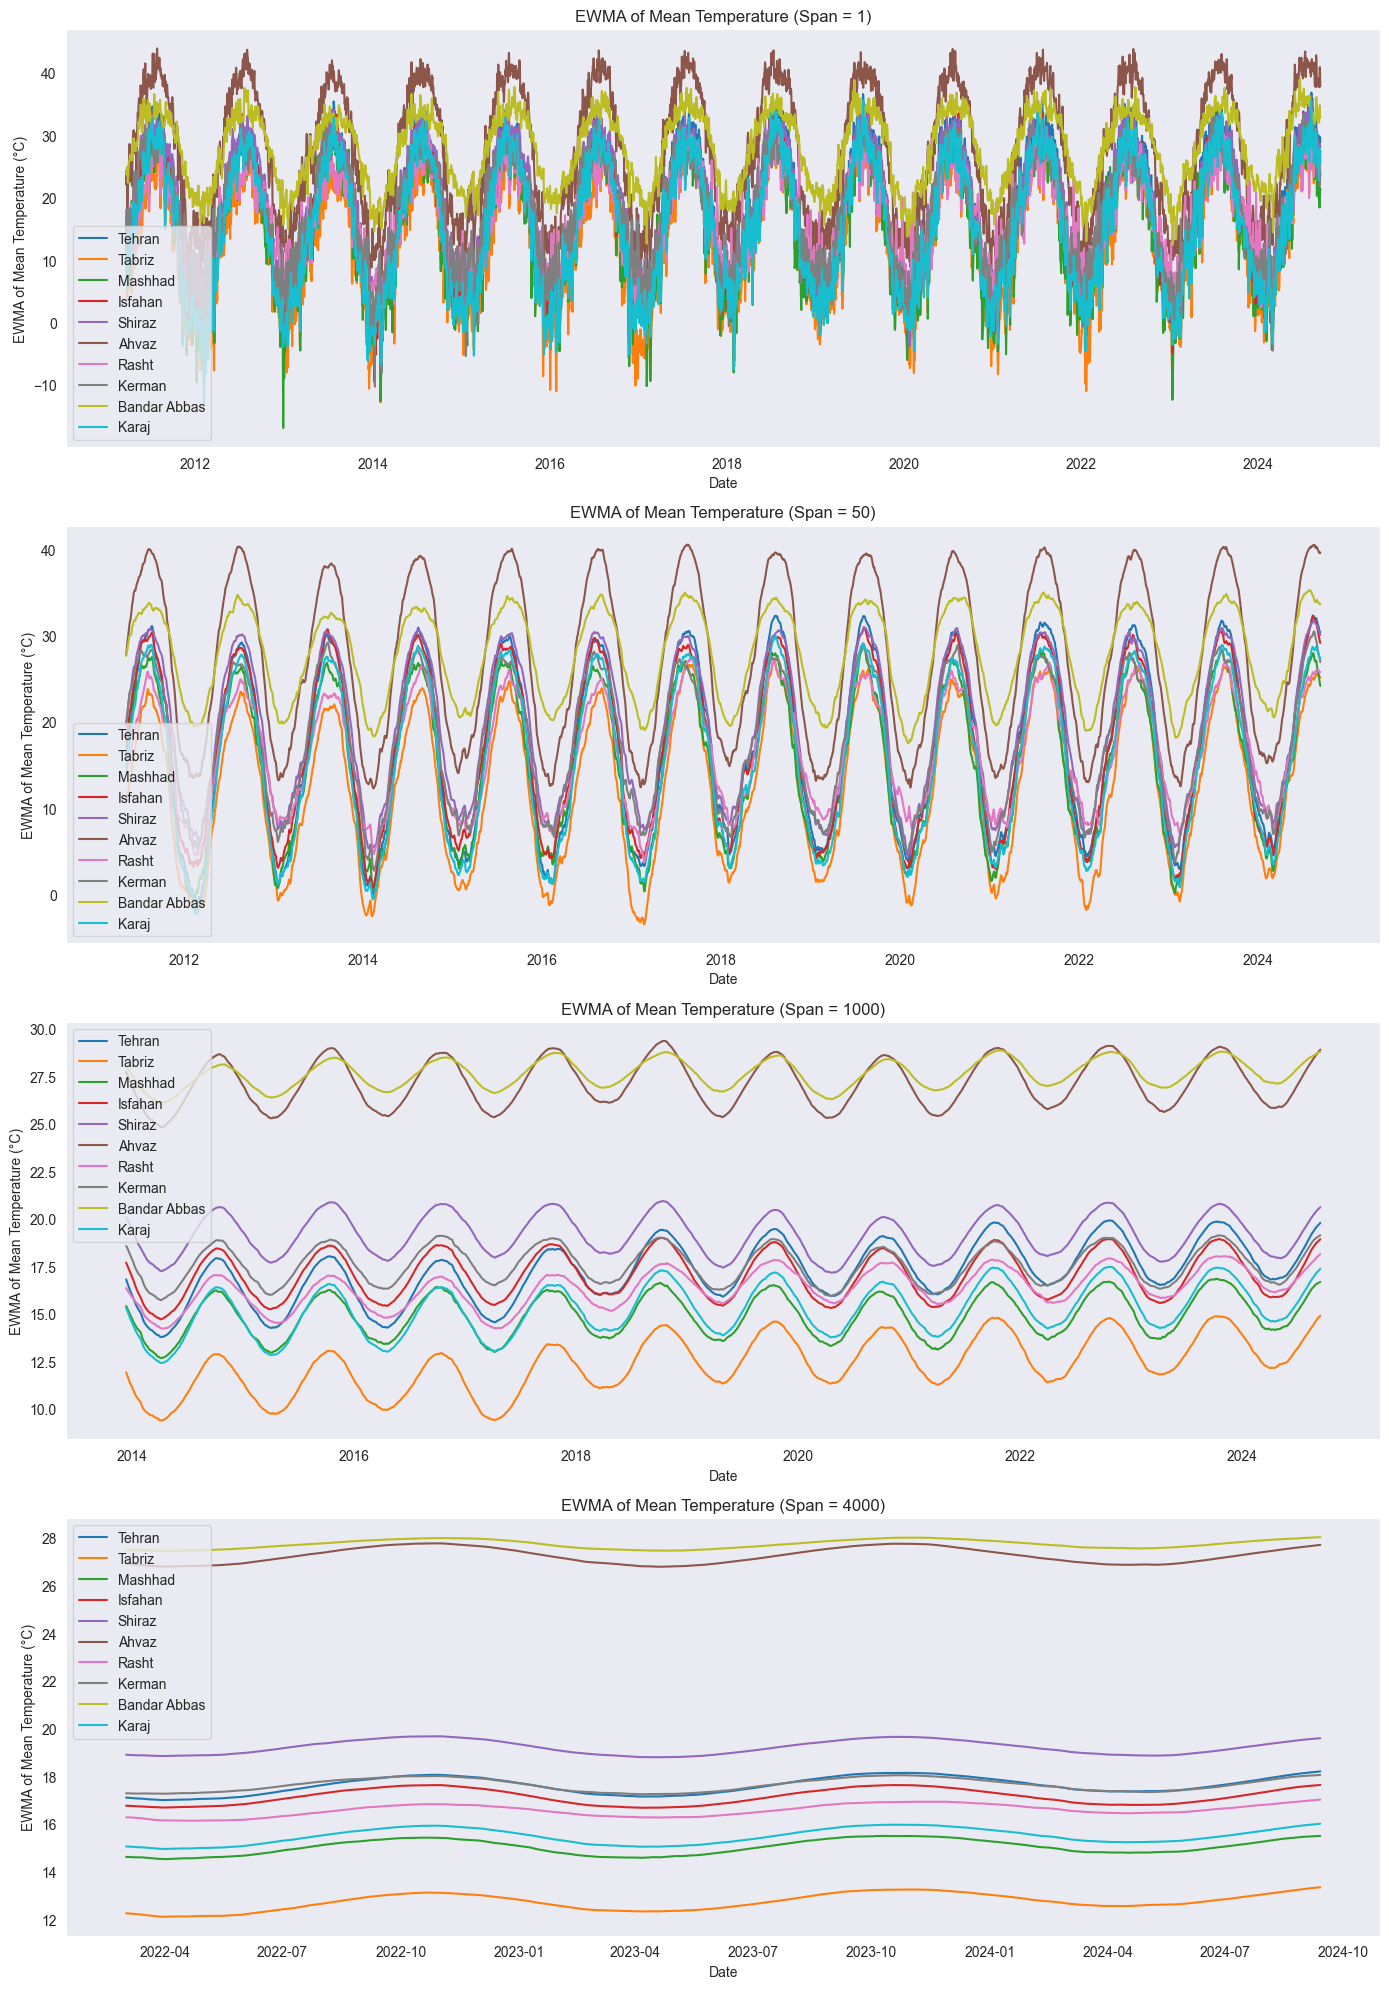

In [402]:
# Define spans for the EWMA
spans = [1, 50, 1000, 4000]

# Create a larger figure
fig, axs = plt.subplots(len(spans), 1, figsize=(14, 20))

for i, span in enumerate(spans):
    for city in df['city'].unique():
        # Calculate EWMA for each city
        city_data = df[df['city'] == city].set_index('date_gregorian')
        ewma_temp = city_data['temp_mean (°C)'].ewm(span=span).mean()

        # Determine the starting point for plotting
        start_index = ewma_temp.index[span - 1]  # Adjust based on the span

        # Plot only from the starting index onward
        axs[i].plot(ewma_temp.index[span - 1:], ewma_temp[span - 1:], label=city)

    # Customize each subplot
    axs[i].set_title(f"EWMA of Mean Temperature (Span = {spans[i]})")
    axs[i].set_xlabel("Date")
    axs[i].set_ylabel("EWMA of Mean Temperature (°C)")
    axs[i].legend()
    axs[i].grid()

plt.tight_layout()
plt.show()


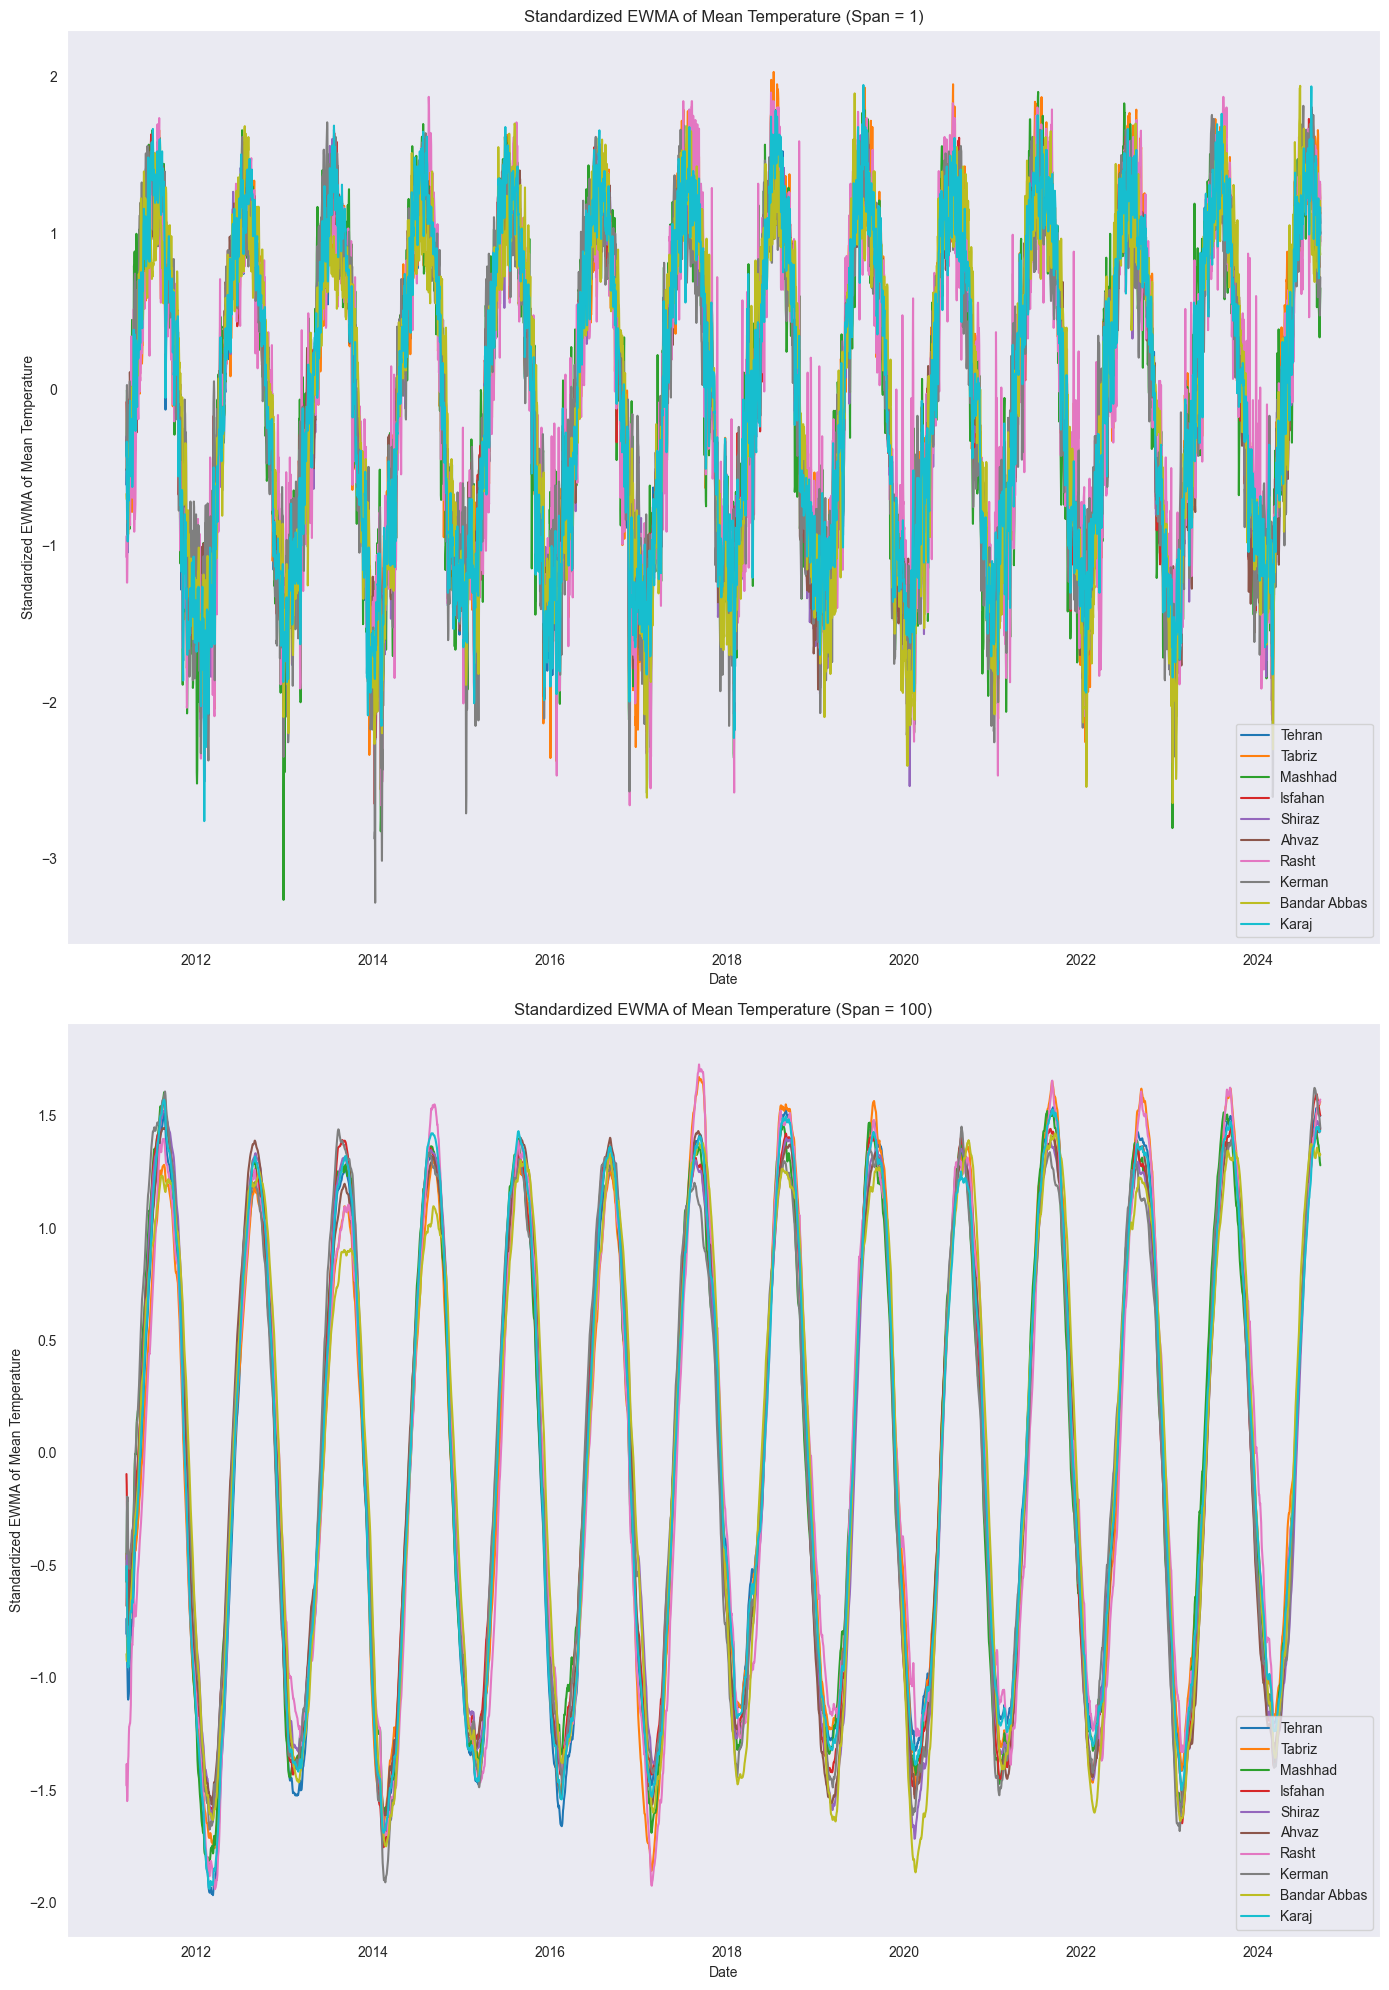

In [432]:
# Define spans for the EWMA
spans = [1, 100]

# Create a larger figure
fig, axs = plt.subplots(len(spans), 1, figsize=(14, 20))

for i, span in enumerate(spans):
    for city in df['city'].unique():
        # Filter data for each city
        city_data = df[df['city'] == city].set_index('date_gregorian')
        
        # Ensure there are enough data points for EWMA calculation
        if city_data.empty or len(city_data) < span:
            print(f"Not enough data for {city}. Skipping.")
            continue

        # Calculate EWMA for each city
        ewma_temp = city_data['temp_mean (°C)'].ewm(span=span).mean()

        # Standardize the EWMA values (Z-score normalization)
        ewma_temp_standardized = (ewma_temp - ewma_temp.mean()) / ewma_temp.std()

        # Plot the standardized EWMA
        axs[i].plot(ewma_temp_standardized.index, ewma_temp_standardized, label=city)

    # Customize each subplot
    axs[i].set_title(f"Standardized EWMA of Mean Temperature (Span = {spans[i]})")
    axs[i].set_xlabel("Date")
    axs[i].set_ylabel("Standardized EWMA of Mean Temperature")
    axs[i].legend()
    axs[i].grid()

plt.tight_layout()
plt.show()


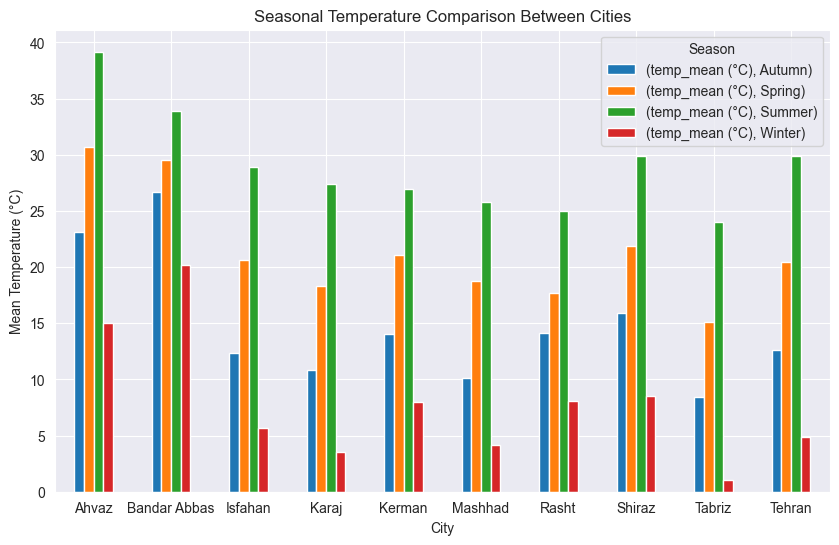

In [403]:
city_season_trends = df.groupby(['city', 'season']).agg({
    'temp_mean (°C)': 'mean',
}).unstack()

# Plotting with adjustments
ax = city_season_trends.plot(kind='bar', figsize=(10, 6))
plt.title("Seasonal Temperature Comparison Between Cities")
plt.xlabel("City")
plt.ylabel("Mean Temperature (°C)")
plt.xticks(rotation=0)  # Make x-axis labels horizontal
plt.legend(title="Season")
plt.show()

### Distance between Max and Min Temperature

#### Full time Analysis

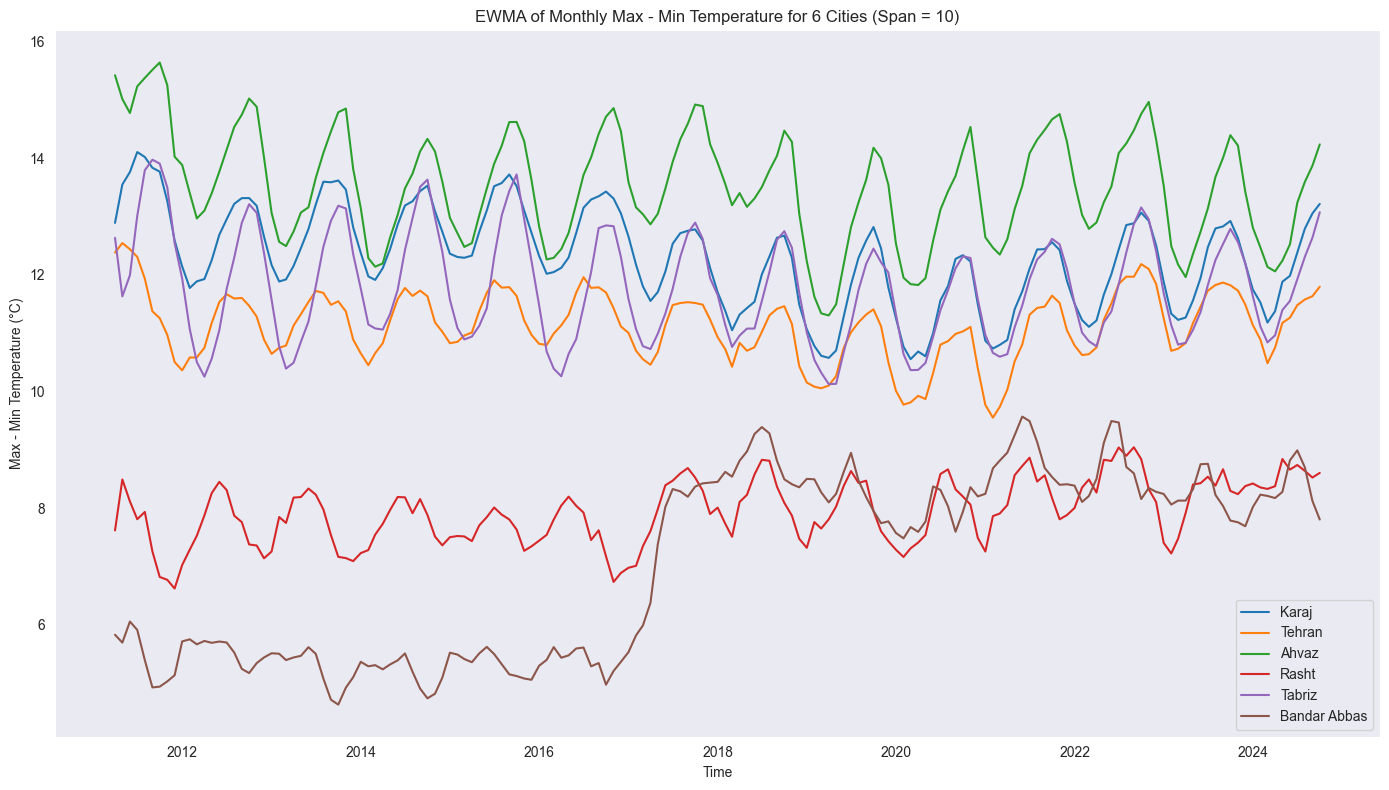

In [437]:
# Ensure temperature columns are numeric  
df['temp_max (°C)'] = pd.to_numeric(df['temp_max (°C)'], errors='coerce')  
df['temp_min (°C)'] = pd.to_numeric(df['temp_min (°C)'], errors='coerce')  

# Drop rows with NaN in the temperature columns before filtering important cities  
df.dropna(subset=['temp_max (°C)', 'temp_min (°C)'], inplace=True)  

# Ensure the date column is in datetime format  
df['date_gregorian'] = pd.to_datetime(df['date_gregorian'])  

# Filter for the 5 important cities  
important_cities = ['Karaj','Tehran', 'Ahvaz', 'Rasht', 'Tabriz', 'Bandar Abbas']  
filtered_data = df[df['city'].isin(important_cities)]  

# Define span for EWMA  
span = 10

# Create a figure  
plt.figure(figsize=(14, 8))  

# Loop through cities and plot on the same figure  
for city in important_cities:  
    city_data = filtered_data[filtered_data['city'] == city].copy()  

    # Check if there's enough data to resample  
    if city_data.empty:  
        print(f"No data available for {city}. Skipping.")  
        continue  

    # Resample data by month-end and calculate monthly mean (use 'ME' instead of 'M')  
    city_monthly = city_data.resample('ME', on='date_gregorian').mean(numeric_only=True)  

    # Calculate Max - Min temperature (monthly mean) and apply EWMA  
    ewma_max_minus_min = (city_monthly['temp_max (°C)'] - city_monthly['temp_min (°C)']).ewm(span=span).mean()  

    # Plot the EWMA for each city  
    plt.plot(ewma_max_minus_min.index, ewma_max_minus_min, label=city)  

# Customize the plot  
plt.title(f"EWMA of Monthly Max - Min Temperature for {len(important_cities)} Cities (Span = {span})")  
plt.xlabel("Time")  
plt.ylabel("Max - Min Temperature (°C)")  
plt.legend()  
plt.grid()  

# Show the plot  
plt.tight_layout()  
plt.show()  

#### Seasonal Analysis

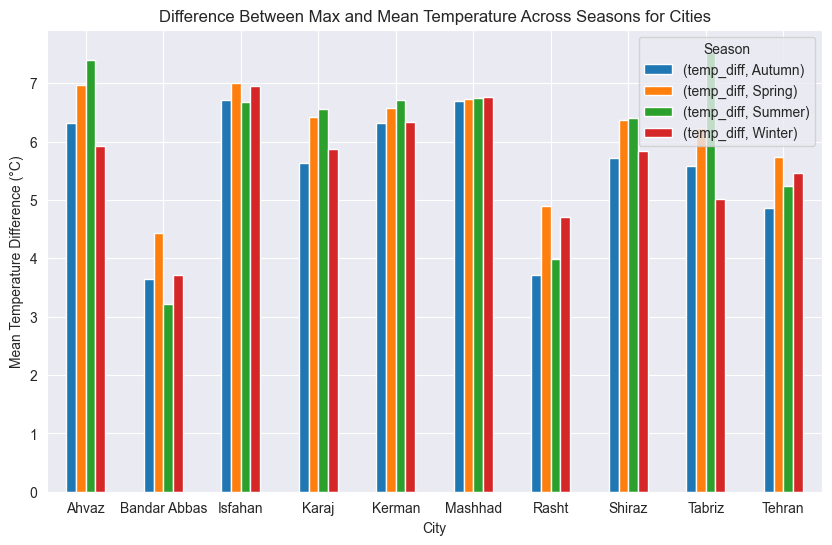

In [405]:
# Calculate the difference between temp_max and temp_mean
df['temp_diff'] = df['temp_max (°C)'] - df['temp_mean (°C)']

# Group by city and season, then aggregate and unstack
city_season_trends = df.groupby(['city', 'season']).agg({
    'temp_diff': 'mean',
}).unstack()

# Plotting the results
ax = city_season_trends.plot(kind='bar', figsize=(10, 6))
plt.title("Difference Between Max and Mean Temperature Across Seasons for Cities")
plt.xlabel("City")
plt.ylabel("Mean Temperature Difference (°C)")
plt.xticks(rotation=0)  # Make x-axis labels horizontal
plt.legend(title="Season")
plt.show()

### Box Plot relationships

#### Monthly time Analysis

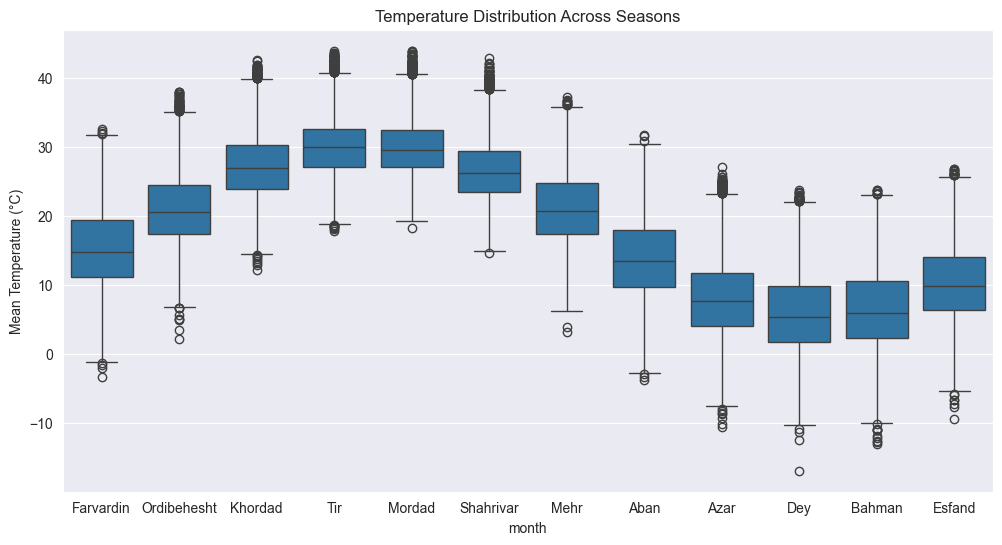

In [406]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='month', y='temp_mean (°C)', data=df)
plt.title("Temperature Distribution Across Seasons")
plt.ylabel("Mean Temperature (°C)")
plt.show()

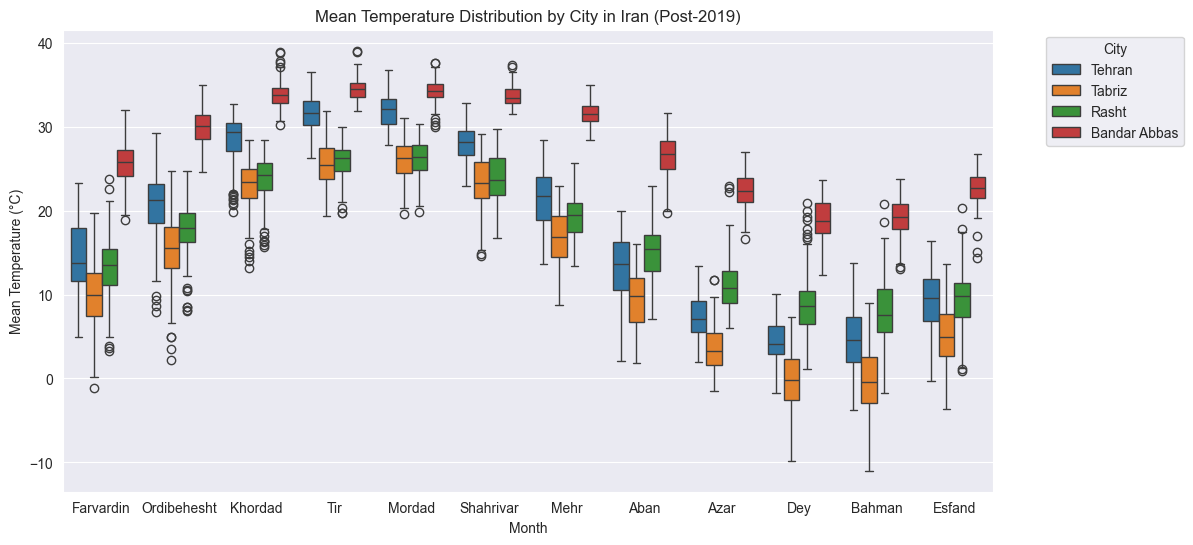

In [407]:
cities_of_interest = ['Tehran', 'Rasht', 'Tabriz', 'Bandar Abbas']
filtered_data = df[(df['city'].isin(cities_of_interest)) & (df['date_gregorian'] > '2019-03-21')]

# Create the boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x='month', y='temp_mean (°C)', hue='city', data=filtered_data)
plt.title("Mean Temperature Distribution by City in Iran (Post-2019)")
plt.ylabel("Mean Temperature (°C)")
plt.xlabel("Month")
plt.legend(title='City', bbox_to_anchor=(1.05, 1), loc='upper left')  # Adjust legend position
plt.show()

#### Seasonal time Analysis

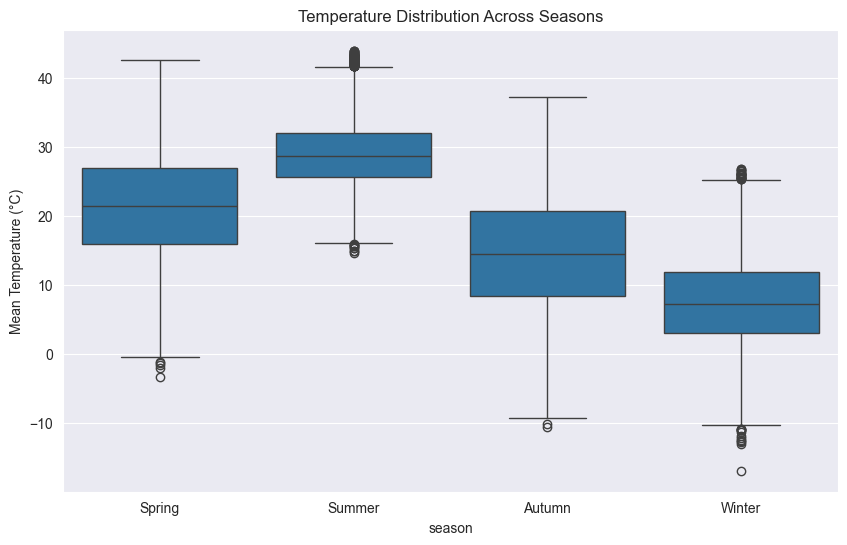

In [408]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='season', y='temp_mean (°C)', data=df)
plt.title("Temperature Distribution Across Seasons")
plt.ylabel("Mean Temperature (°C)")
plt.show()

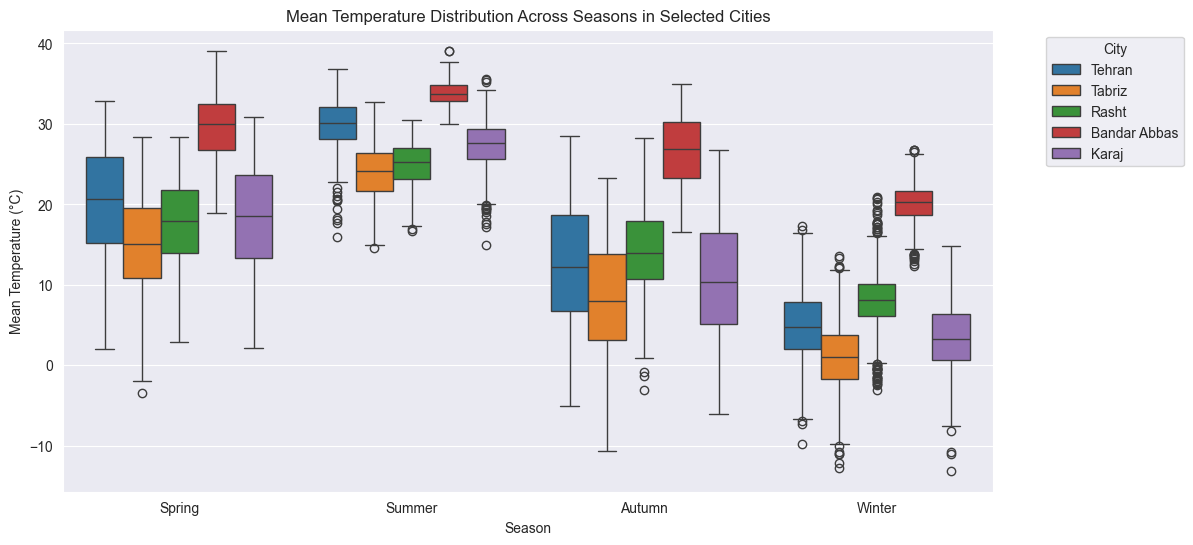

In [409]:
# Filter the DataFrame for the relevant cities
cities_of_interest = ['Tehran', 'Rasht', 'Tabriz', 'Karaj', 'Bandar Abbas']
seasonal_data = df[df['city'].isin(cities_of_interest)]

# Create the boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x='season', y='temp_mean (°C)', hue='city', data=seasonal_data)
plt.title("Mean Temperature Distribution Across Seasons in Selected Cities")
plt.ylabel("Mean Temperature (°C)")
plt.xlabel("Season")
plt.legend(title='City', bbox_to_anchor=(1.05, 1), loc='upper left')  # Adjust legend position
plt.show()


## Precipitation Analysis

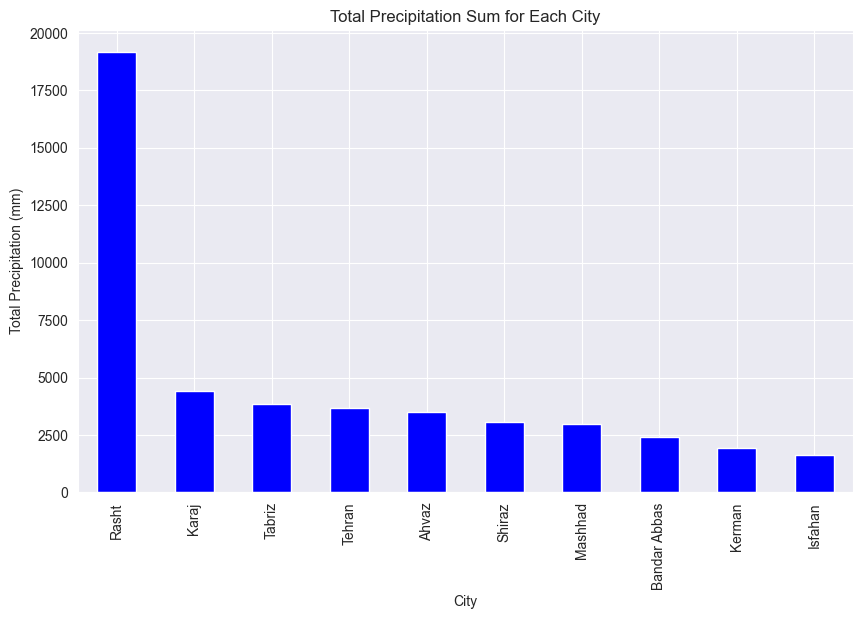

In [410]:
city_precip = df.groupby('city')['precipitation_sum (mm)'].sum().sort_values(ascending=False)
city_precip.plot(kind='bar', figsize=(10, 6), color='blue')
plt.title("Total Precipitation Sum for Each City")
plt.ylabel("Total Precipitation (mm)")
plt.xlabel("City")
plt.show()

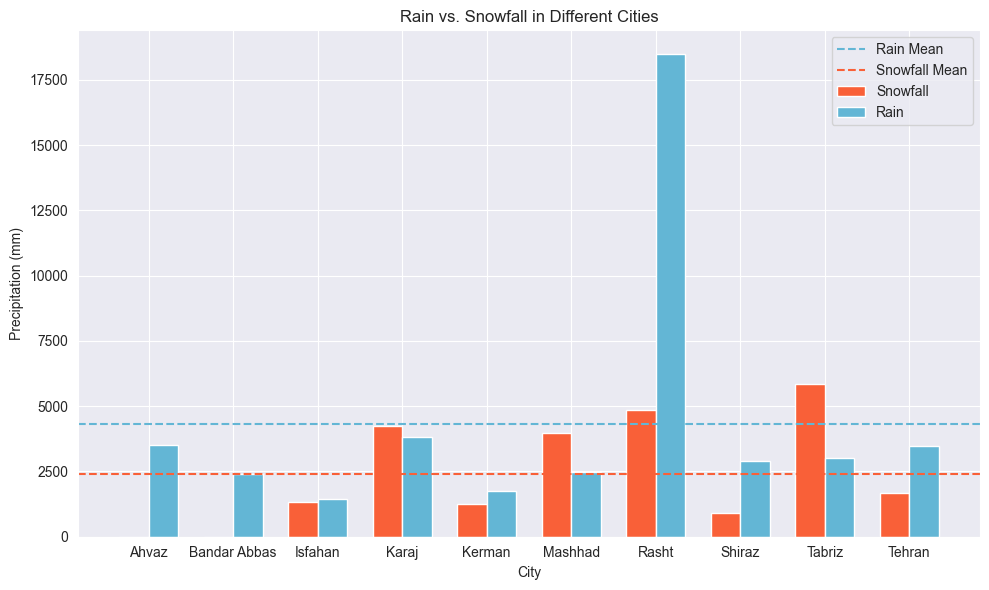

In [411]:
# Group the data by city and sum the precipitation
city_precip = df.groupby('city')[['rain_sum (mm)', 'snowfall_sum (mm)']].sum()
bar_width = 0.35  # Width of the bars
x = range(len(city_precip))  # The x positions for the groups

plt.figure(figsize=(10, 6))

# Plot snowfall
plt.bar(x, city_precip['snowfall_sum (mm)'], width=bar_width, label='Snowfall', color='#f96038')

# Plot rain with an offset
plt.bar([p + bar_width for p in x], city_precip['rain_sum (mm)'], width=bar_width, label='Rain', color='#63b6d5')

# Calculate means and standard deviations
rainfall_mean = city_precip['rain_sum (mm)'].mean()
snowfall_mean = city_precip['snowfall_sum (mm)'].mean()
rainfall_std = city_precip['rain_sum (mm)'].std()
snowfall_std = city_precip['snowfall_sum (mm)'].std()

# Add mean for rainfall
plt.axhline(y=rainfall_mean, color='#63b6d5', linestyle='--', label='Rain Mean')

# Add mean for snowfall
plt.axhline(y=snowfall_mean, color='#f96038', linestyle='--', label='Snowfall Mean')

# Add titles and labels
plt.title("Rain vs. Snowfall in Different Cities")
plt.ylabel("Precipitation (mm)")
plt.xlabel("City")
plt.xticks([p + bar_width / 2 for p in x], city_precip.index)  # Center the tick labels
plt.legend()
plt.tight_layout()
plt.show()

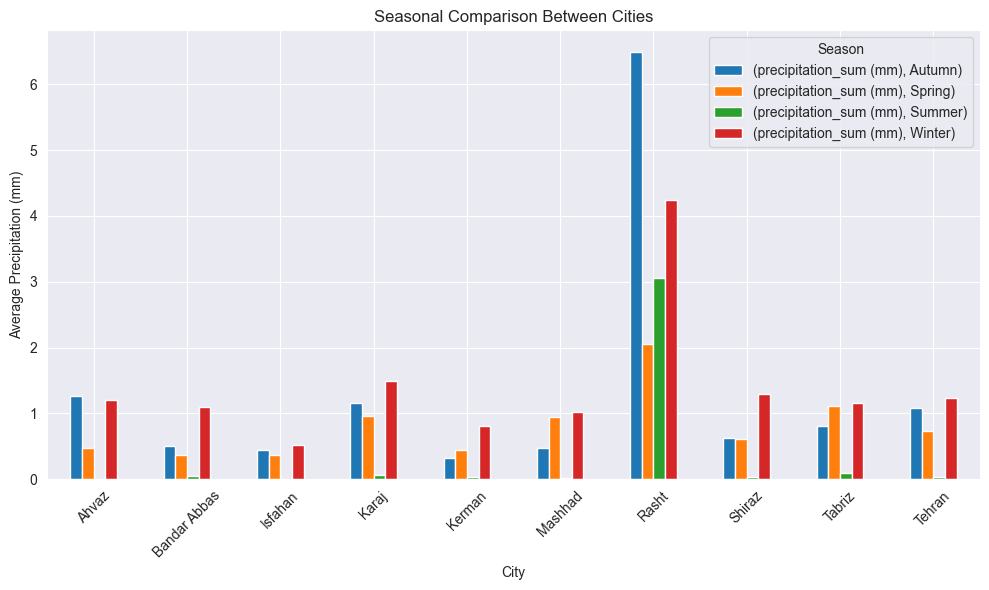

In [412]:
city_season_trends = df.groupby(['city', 'season']).agg({
    'precipitation_sum (mm)': 'mean',
}).unstack()

# Plot the bar chart with improvements
ax = city_season_trends.plot(kind='bar', figsize=(10, 6), title="Seasonal Comparison Between Cities")
ax.set_xlabel("City")
ax.set_ylabel("Average Precipitation (mm)")
ax.legend(title="Season")
plt.xticks(rotation=45)  # Rotate the city names for readability
plt.tight_layout()  # Adjust layout for better fit
plt.show()

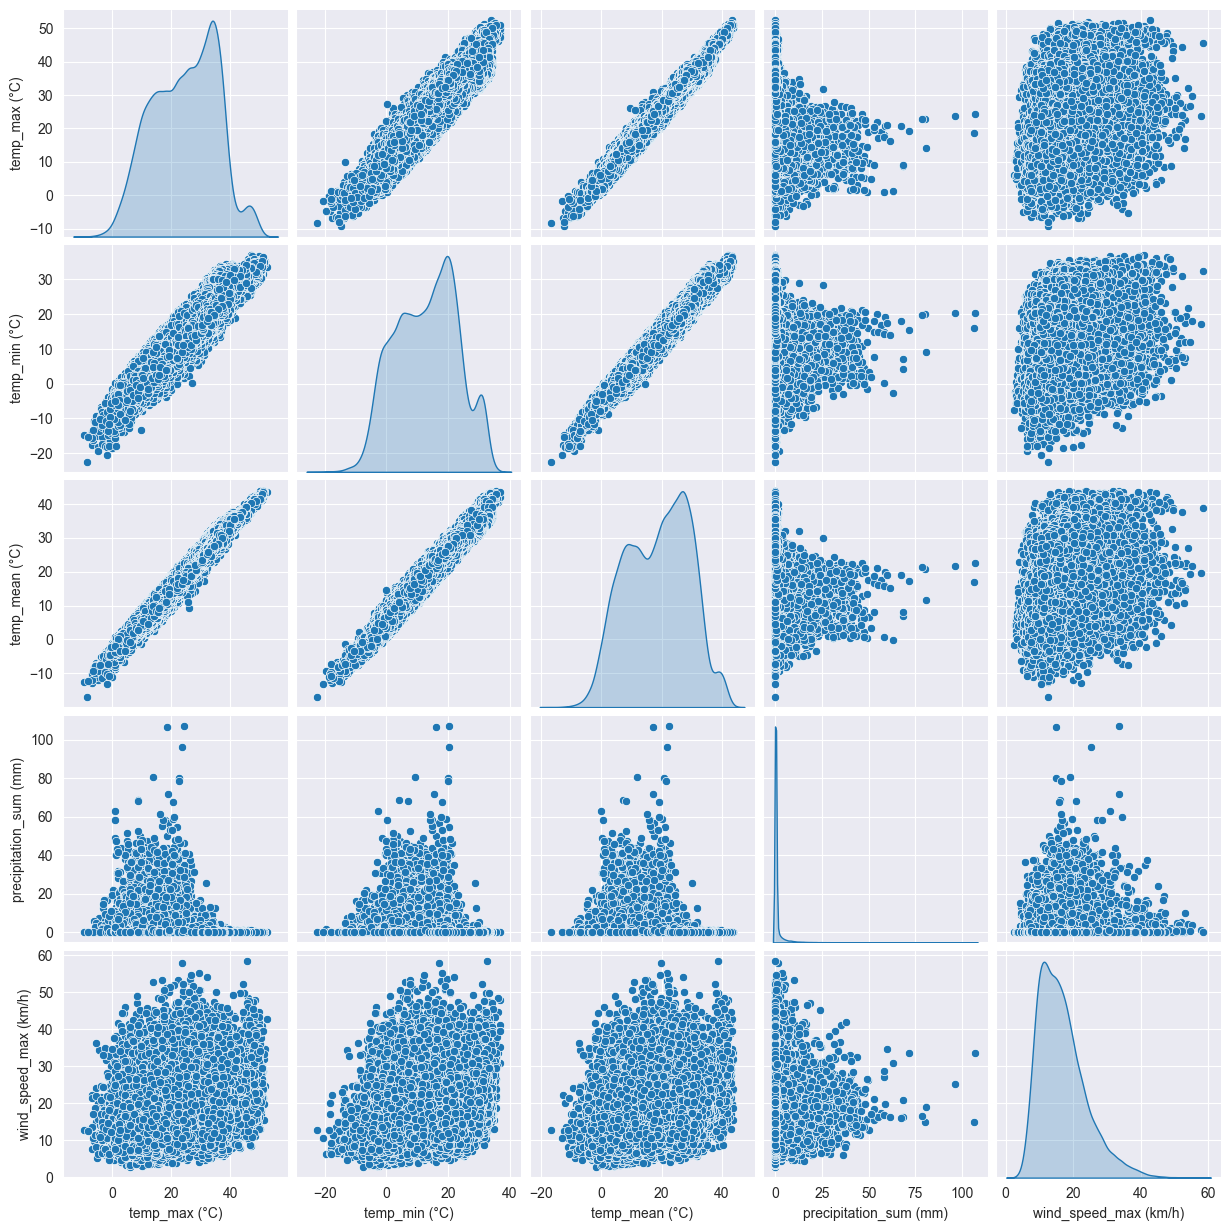

In [435]:
# Select the features you want to include in the pairplot
features = ['temp_max (°C)', 'temp_min (°C)', 'temp_mean (°C)', 'precipitation_sum (mm)', 'wind_speed_max (km/h)']

# Create the pairplot
sns.pairplot(df[features], diag_kind='kde')

# Show the plot
plt.show()


array([<Axes: title={'center': 'temp_mean (°C)'}, xlabel='city'>,
       <Axes: title={'center': 'precipitation_sum (mm)'}, xlabel='city'>,
       <Axes: title={'center': 'wind_speed_max (km/h)'}, xlabel='city'>],
      dtype=object)

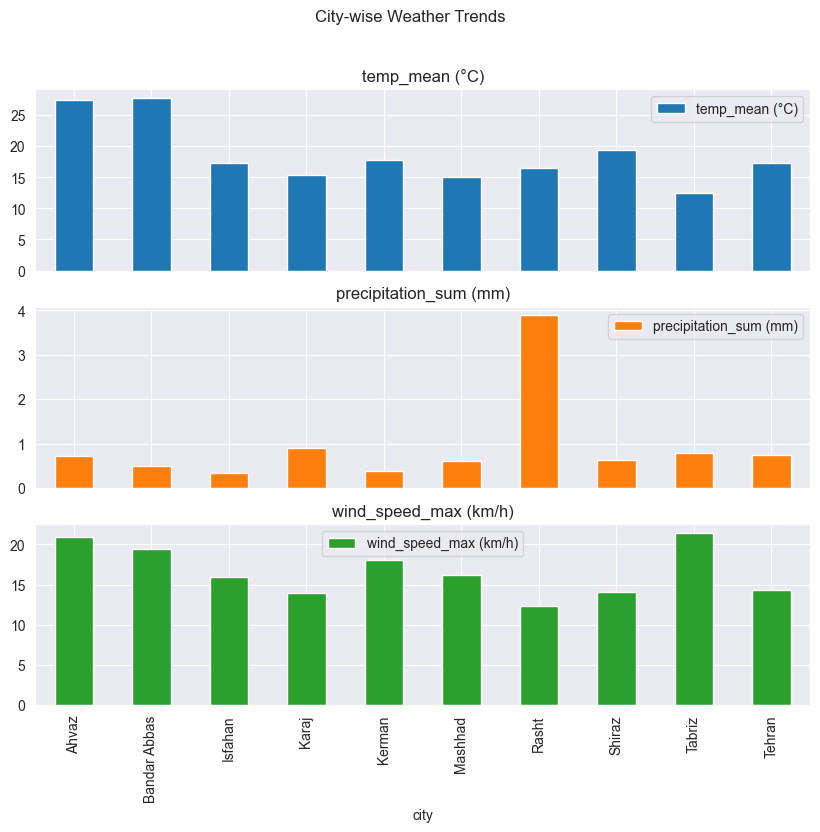

In [413]:
city_trends = df.groupby('city').agg({
    'temp_mean (°C)': 'mean',
    'precipitation_sum (mm)': 'mean',
    'wind_speed_max (km/h)': 'mean'
})
city_trends.plot(kind='bar', subplots=True, figsize=(10, 8), title="City-wise Weather Trends")